In [49]:
pip install pymorphy3




SyntaxError: invalid syntax (<ipython-input-49-0b3dbee5410b>, line 1)

In [67]:
pip install wordcloud matplotlib

In [69]:
import json
import re
import plotly.express as px

from collections import Counter
import nltk
from nltk.corpus import stopwords
import pymorphy3

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# общая функция для парсинга ТГ каналов

In [63]:

def get_text(message):
    #функция достает текст
    if 'text' not in message:
        return ""

    text = message['text']
    if isinstance(text, str):
        return text.lower()
    elif isinstance(text, list):
        result = []
        for item in text:
            if isinstance(item, dict) and 'text' in item:
                result.append(item['text'])
            elif isinstance(item, str):
                result.append(item)
        return ' '.join(result).lower()
    return ""

#делает все остальное
def analyze_file(file_name, words_postuplenie, words_education, words_promo, name):
    with open(file_name, 'r', encoding='utf-8') as file:
        data = json.load(file)

    total = 0
    polls = 0
    education_count = 0
    postuplenie_count = 0
    promo_count = 0
    used = set()

    # создаем регулярки для всех слов
    regex = {}
    for word in words_postuplenie + words_education + words_promo:
        regex[word] = re.compile(rf"\b{re.escape(word)}\w*\b", re.IGNORECASE)

    for msg in data['messages']:
        if msg['type'] != 'message':
            continue

        text = get_text(msg)
        if not text:
            if 'poll' in msg:
                polls += 1
                used.add(msg['id'])
            continue

        total += 1

        if msg['id'] in used:
            continue

        # поступление
        if any(regex[word].search(text) for word in words_postuplenie):
            postuplenie_count += 1
            used.add(msg['id'])
            continue

        # образовательный контент
        if any(regex[word].search(text) for word in words_education):
            education_count += 1
            used.add(msg['id'])
            continue

        # ПРОМО
        if any(regex[word].search(text) for word in words_promo):
            promo_count += 1
            used.add(msg['id'])
            continue

    other = total - len(used)

    stats = {
        "Поступление": postuplenie_count,
        "Образовательный контент": education_count,
        "ПРОМО": promo_count,
        "Опросы": polls,
        "Остальные посты": other
    }

    #палииииитра
    colors = {
        "Поступление": "#b2f2bb",  # салатовый
        "Образовательный контент": "#a3d8f4",  # голубой
        "ПРОМО": "#ffb3ba",  # розовый
        "Опросы": "#ffdfba",  # жёлтый
        "Остальные посты": "#d3d3d3",  # серый
    }

    #диаграммка
    chart = px.pie(
        names=list(stats.keys()),
        values=list(stats.values()),
        title=f'Посты по категориям в "{name}"',
        hole=0.2,
        color=list(stats.keys()),
        color_discrete_map=colors,
    )

    chart.update_traces(textposition='inside', textinfo='percent+label')
    chart.update_layout(showlegend=True)
    chart.show()



# Парсинг Умбрии Олимп

Давайте поймем, что для того, чтобы понять, какие слова использовать, нужно понять, какие вообще есть слова. Найдем 100 самых частых слов, только аккуратно.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


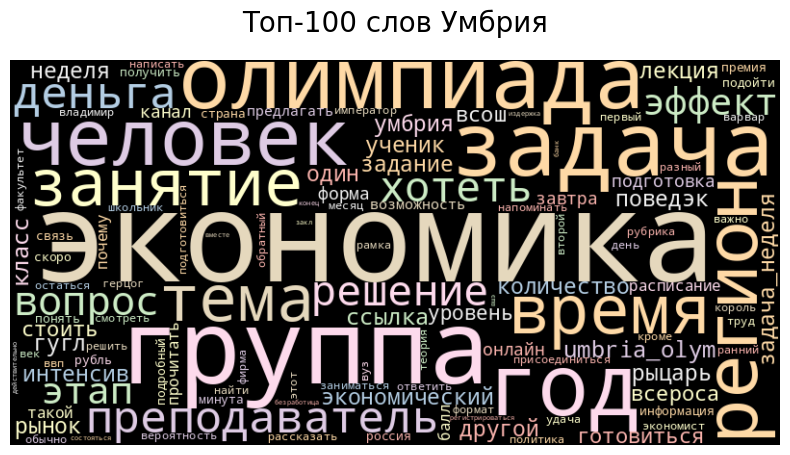

In [116]:

# стоп-слова хехехе
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

with open('result.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

all_words = []
for msg in data['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако", "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например", "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота", "воскресение", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Умбрия", fontsize=20, pad=20, color='black')
plt.show()

In [89]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет", "факультет", "вуз", "бакалавр"]
education_keywords = ["вебинар", "лектори", "совет", "эфир", "рекоменд", "пробн", "разбор", "бесплатн", "#поведэк", "#нобелевка", "#макра", "#задача_недели"]
promo_keywords = ["хочу", "зарегистрироваться", "групп", "интенсив", "присоедин", "запис", "узнать подробнее", "готовиться", "регистр", "купить", "получить", "форм"]

analyze_file('result.json', postuplenie_keywords, education_keywords, promo_keywords, "Умбрия")

# Парсинг Олмат Экономики

Парсим все слова, убирая незначащие, и находим 100 самых популярных

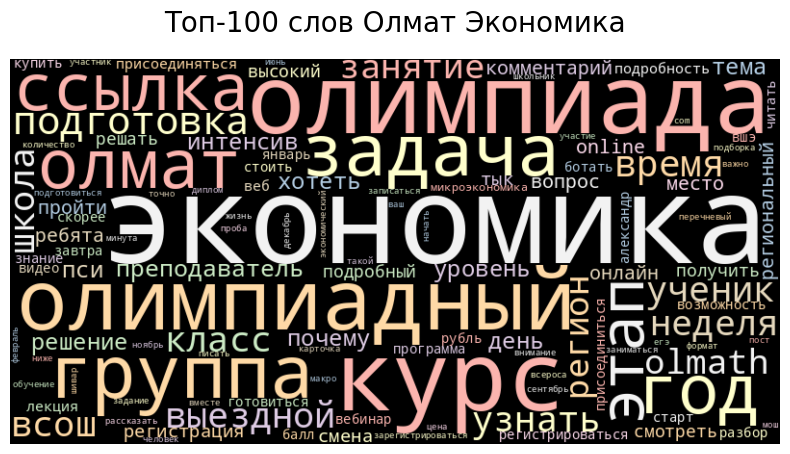

In [113]:


with open('olmath.json', 'r', encoding='utf-8') as f:
    data1 = json.load(f)

all_words = []
for msg in data1['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако", "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например", "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Олмат Экономика", fontsize=20, pad=20, color='black')
plt.show()

In [101]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет", "факультет", "вуз", "бакалавр"]
education_keywords = ["вебинар", "лектори", "совет", "эфир", "рекоменд", "пробн", "разбор", "бесплатн"]
promo_keywords = ["хочу", "зарегистрироваться", "курс", "интенсив", "присоедин", "запис", "узнать подробнее", "готовиться", "регистр", "купить", "получить", "форм"]

analyze_file('olmath.json', postuplenie_keywords, education_keywords, promo_keywords, "Олмат Экономика")

# Парсинг КСИ образования

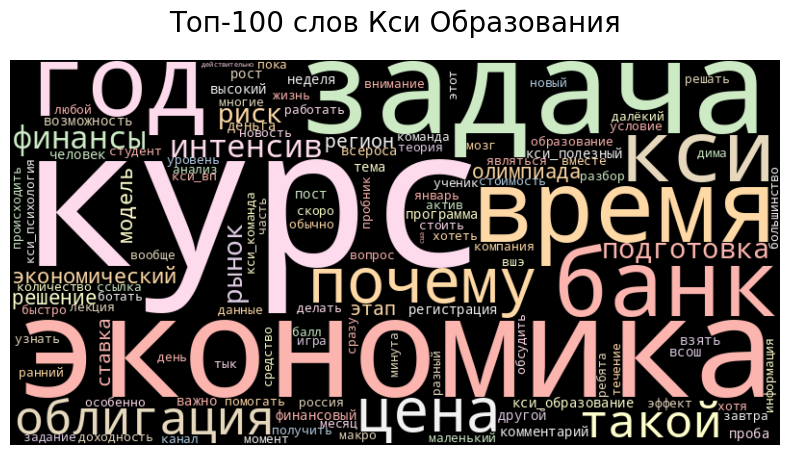

In [114]:

with open('ksi.json', 'r', encoding='utf-8') as f:
    data2 = json.load(f)

all_words = []
for msg in data2['messages']:
    if msg['type'] != 'message':
        continue

    text = msg['text']
    if isinstance(text, str):
        text = text.lower()
    elif isinstance(text, list):
        text = ' '.join([item['text'] if isinstance(item, dict) else item for item in text]).lower()

    #разбиваем на слова
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2 and not word.isdigit()]
    all_words.extend(filtered)

word_counts = Counter(all_words)

top_words = word_counts.most_common(200)

lemma_counts = Counter()
for word, count in top_words:
    lemma = morph.parse(word)[0].normal_form
    lemma_counts[lemma] += count

# смотрим глазками и выкидываем чушь
exclude = {
    "это", "эта", "эти", "каждый", "также", "свой", "просто", "быть", "однако", "смочь", "ждать", "мочь", "900р",
    "который", "наш", "очень", "поэтому", "сегодня", "всё", "кстати", "например", "тот", "весь", "самый", "именно", "сам",
    "понедельник", "https", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье", "минь", "мы", "ещё",
    "значит", "нужно", "часто", "сделать", "несколько", "давать", "либо", "какой"
}
filtered = {lemma: count for lemma, count in lemma_counts.items() if lemma not in exclude}

# колдуем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Pastel1',
    max_words=150,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Топ-100 слов Кси Образования", fontsize=20, pad=20, color='black')
plt.show()

In [125]:

postuplenie_keywords = ["поступлени", "поступа", "интервью", "университет",
                        "факультет", "вуз", "бакалавр", "#КСИ_поступление"]
education_keywords = ["вебинар", "лектори", "совет", "эфир", "рекоменд", "пробн", "разбор",
                      "КСИ_задача", "КСИ_команда", "КСИ_психология", "КСИ_книги", "КСИ_полезное" ]
promo_keywords = ["хочу", "КСИ_отзывы" "зарегистрироваться", "курс", "интенсив",
                  "присоедин", "запис", "узнать подробнее", "готовиться", "регистр",
                  "купить", "получить", "форм", "КСИ_Взять_Всерос", "КСИ_Взять_Всерос_закл",
                  "КСИ_Финансы", "КСИ_регион", "КСИ_ВП", "КСИ_На_старт"]

analyze_file('ksi.json', postuplenie_keywords, education_keywords, promo_keywords, "Кси Образование")